# Исследование данных мобильного приложения по продаже продуктов питания

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

Исследование пройдет в 5 этапов:

1. Обзор данных.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Изучение воронки событий.
5. Анализ результатов эксперимента.

### Обзор данных

In [1]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from plotly import graph_objects as go
import math as mth
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [2]:
try:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv(r'C:\Users\katya\Downloads\logs_exp.csv', sep='\t')
    
display(logs.head(10))
logs.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Предобработка данных

Заменим названия столбцов на более удобные:

In [3]:
logs = logs.rename(columns={"EventName": "event_name", "DeviceIDHash": "user_id", "EventTimestamp": "event_time", "ExpId": "group"})

Поменяем тип столбца "event_time" на datetime и добавим отдельный столбец дат:

In [4]:
logs['event_time'] = pd.to_datetime(logs['event_time'], unit='s')
logs['event_date'] = logs['event_time'].astype('datetime64[D]')


Посчитаем количество пропусков и дубликатов:

In [5]:
print(logs.isna().sum()) # посчитаем количество пропусков в столбцах
print('Количество явных дубликатов:',logs.duplicated().sum()) # подсчёт явных дубликатов

event_name    0
user_id       0
event_time    0
group         0
event_date    0
dtype: int64
Количество явных дубликатов: 413


Пропусков в данных не оказалось, а вот дубликатов - 413. Дубликаты можно удалить. 

In [6]:
logs = logs.drop_duplicates().reset_index(drop=True)

In [7]:
logs.info()
logs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   event_date  243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


,event_name,user_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 11:48:42


На этапе предобработки данных мы заменили названия столбцов на более удобные; поменяли тип столбца с датой на 'datetime' и отдельно добавили столбец с датой без времени; так же мы избавились от 413 дубликатов в данных.

### Исследовательский анализ данных

Определим, сколько всего событий в логе:

In [8]:
print('Количество событий в логе: ', logs['event_name'].count())

Количество событий в логе:  243713


Определим, сколько всего пользователей в логе:

In [9]:
print('Количество пользователей в логе: ', logs['user_id'].nunique())

Количество пользователей в логе:  7551


Определим, сколько в среднем событий приходится на пользователя:

In [10]:
print('Среднее количество событий на пользователя: ', int(logs.groupby('user_id')['event_name'].agg('count').median()))

Среднее количество событий на пользователя:  20


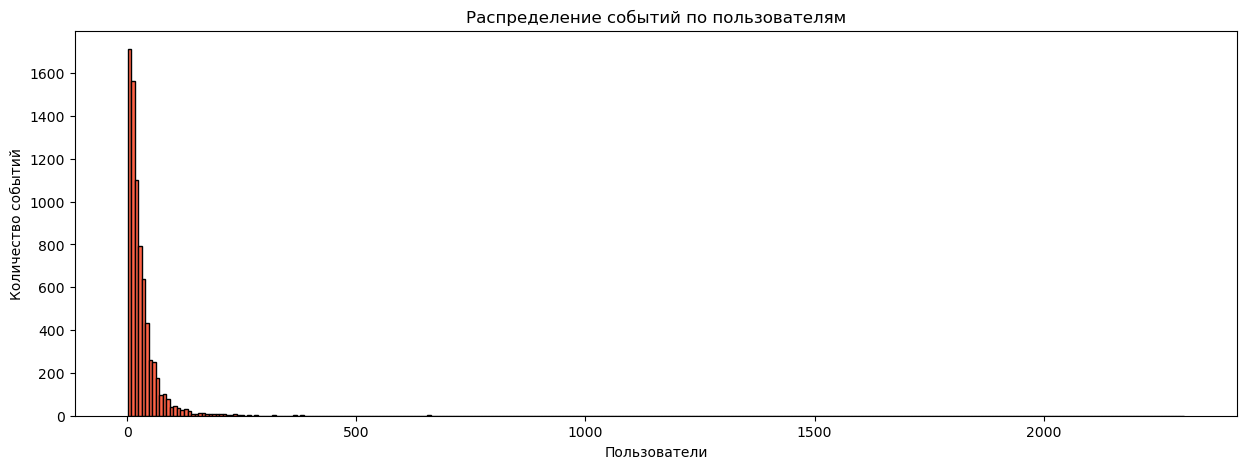

In [11]:
event_sum = logs.groupby('user_id').agg({'event_name': 'count'})
plt.figure(figsize=(15,5))
plt.title("Распределение событий по пользователям")
plt.xlabel("Пользователи")
plt.ylabel("Количество событий")
plt.hist(event_sum, color = 'tomato', edgecolor = 'black', bins=300)
plt.show()

По гистограмме можно сделать вывод, что есть небольшая доля пользователей, совершивших гораздо больше событий, чем большая часть пользователей (в тысячи раз). Гистограмма напоминает экспоненциальное распределение.

Найдем максимальную и минимальную дату (период, данными за который мы располагаем). 

In [12]:
print('Минимальная дата:', logs['event_time'].min())
print('Максимальная дата:', logs['event_time'].max())

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17


Построим гистограмму по дате: 

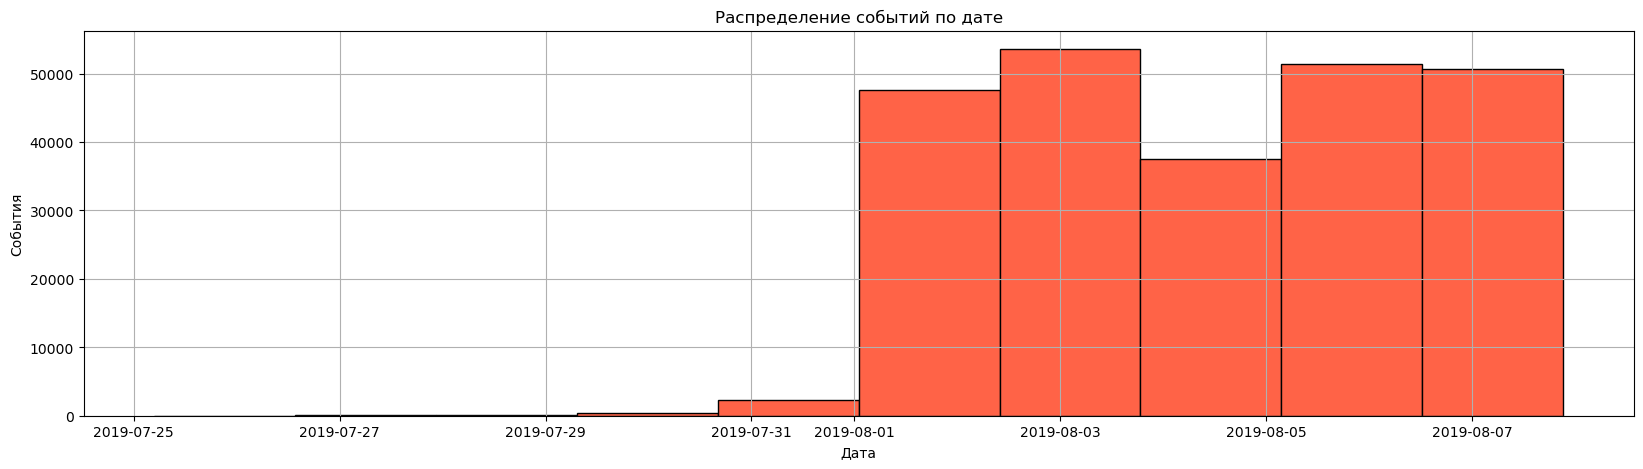

In [13]:
plt.title("Распределение событий по дате")
plt.xlabel("Дата")
plt.ylabel("События")
logs['event_date'].hist(figsize=(20, 5),color = "tomato",edgecolor = 'black')
plt.show()

Построим гистограмму по времени:

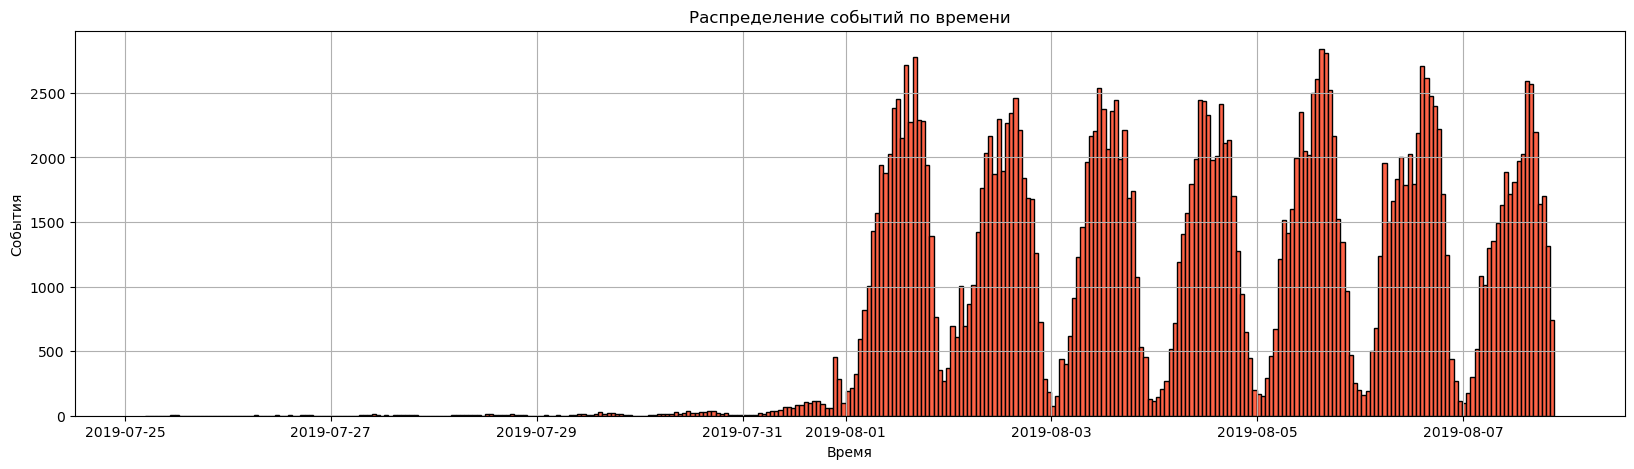

In [14]:
plt.title("Распределение событий по времени")
plt.xlabel("Время")
plt.ylabel("События")
logs['event_time'].hist(bins=14*24,figsize=(20, 5),color = "tomato",edgecolor = 'black')
plt.show()

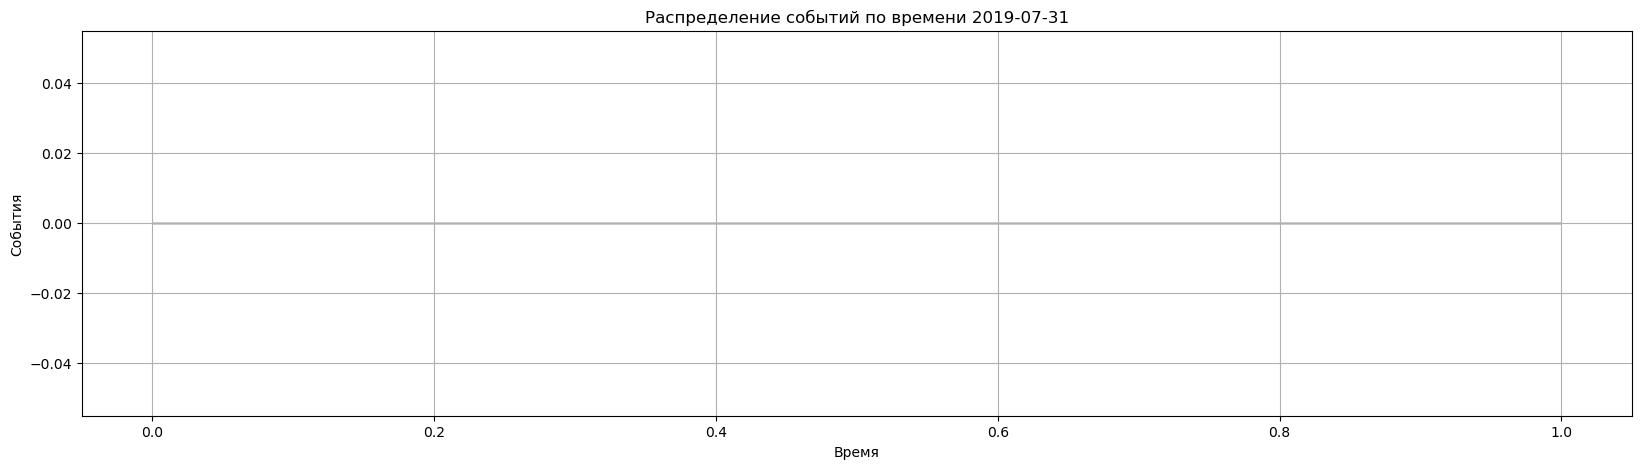

In [15]:
plt.title("Распределение событий по времени 2019-07-31")
plt.xlabel("Время")
plt.ylabel("События")
logs.query('event_date=="2019-07-31"')['event_time'].hist(bins=24,figsize=(20, 5),color = "tomato",edgecolor = 'black')
plt.show()

Судя по гистограммам, можно сделать вывод, что у нас одинаково полные данные только за период с 2019-07-31 21:00:57 по 2019-08-07 21:15:17. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».

Отбросим старые данные и построим новые гистограммы:

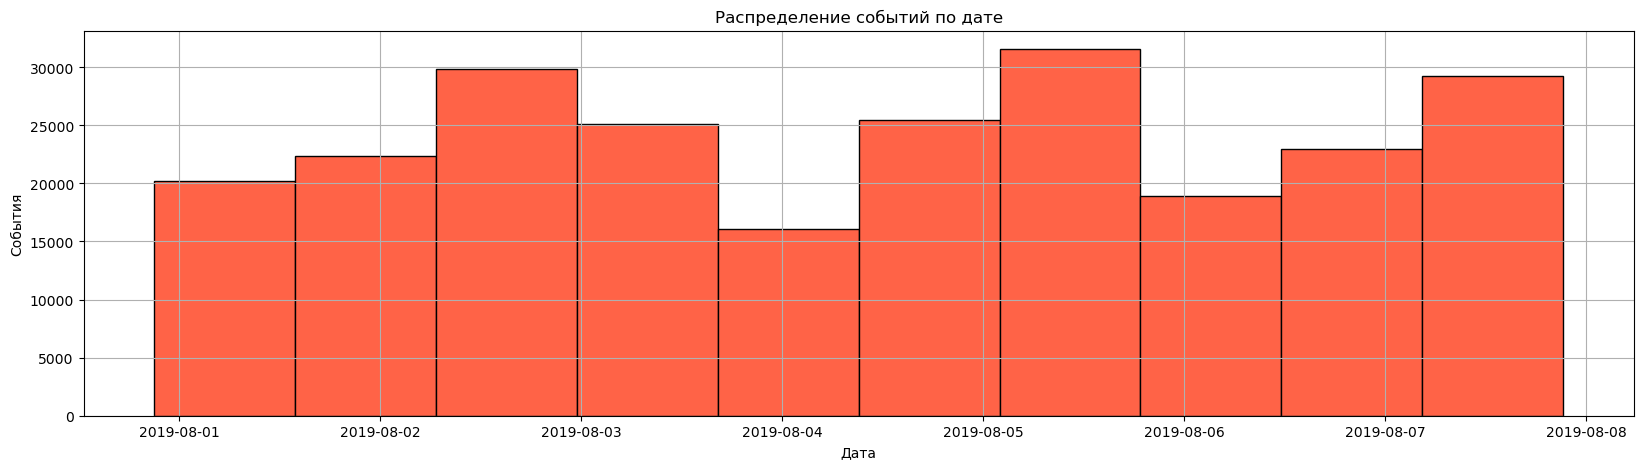

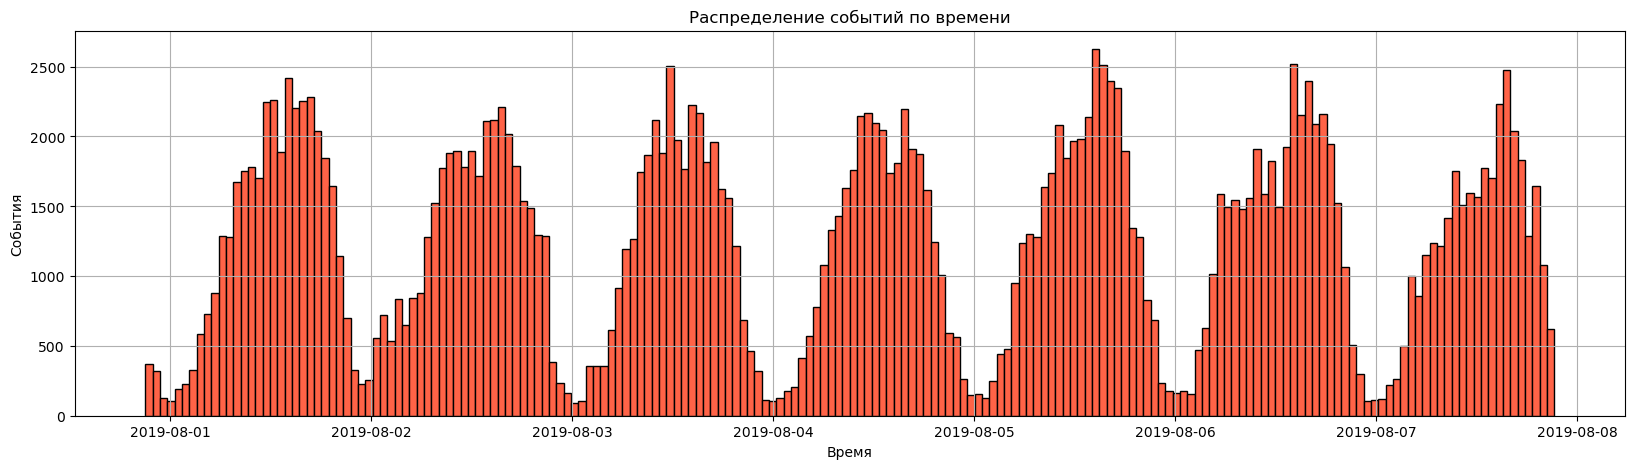

In [16]:
new_logs = logs['2019-07-31 21:00:00' <= logs['event_time']]
plt.title("Распределение событий по дате")
plt.xlabel("Дата")
plt.ylabel("События")
new_logs['event_date'].hist(figsize=(20, 5),color = "tomato",edgecolor = 'black')
plt.show()
plt.title("Распределение событий по времени")
plt.xlabel("Время")
plt.ylabel("События")
new_logs['event_time'].hist(bins=8*24,figsize=(20, 5),color = "tomato",edgecolor = 'black')
plt.show()

Определим количество событий и пользователей для новых данных:

In [17]:
print('Количество событий в логе: ', new_logs['event_name'].count())
print('Количество пользователей в логе: ', new_logs['user_id'].nunique())
print('Среднее количество событий на пользователя: ', int(new_logs.groupby('user_id')['event_name'].agg('count').median()))
print('Минимальная дата:', new_logs['event_time'].min())
print('Максимальная дата:', new_logs['event_time'].max())

Количество событий в логе:  241724
Количество пользователей в логе:  7538
Среднее количество событий на пользователя:  19
Минимальная дата: 2019-07-31 21:00:57
Максимальная дата: 2019-08-07 21:15:17


Определим количество потерянных после удаления событий и пользователей:

In [18]:
drop_events = logs['event_name'].count()-new_logs['event_name'].count()
percent_events = drop_events/logs['event_name'].count()*100
drop_users = logs['user_id'].nunique()-new_logs['user_id'].nunique()
percent_users = drop_users/logs['user_id'].nunique()*100
print('Количество удаленных событий:', drop_events)
print('Процент удаленных событий от общего числа событий:', round(percent_events,2), '%')
print('Количество удаленных пользователей:', drop_users)
print('Процент удаленных пользователей от общего числа пользователей:', round(percent_users,2), '%')

Количество удаленных событий: 1989
Процент удаленных событий от общего числа событий: 0.82 %
Количество удаленных пользователей: 13
Процент удаленных пользователей от общего числа пользователей: 0.17 %


Проверим, есть ли пользователи из всех трёх экспериментальных групп:

In [19]:
print(new_logs.groupby('user_id').agg({'group' : 'nunique'}).query('group>1').count())

group    0
dtype: int64


Оказалось, что в данных нет пользователей, которые попали сразу в несколько групп. Значит ошибки в сборе данных нет.

На этапе исследовательского анализа данных мы определили, что у нас одинаково полные данные только за период с 2019-07-31 21:00:57 по 2019-08-07 21:15:17 и отбросили ненужные данные. Определили количество потерянных после удаления событий и пользователей (их оказалось немного, 0.82 % удаленных событий от общего числа событий и 0.17 % удаленных пользователей от общего числа пользователей). Так же мы посчитали количество событий и пользователей в логе, среднее количество событий на пользователя. Проверили, есть ли пользователи, попавшие сразу в несколько эспериментальных групп, и определили, что таких пользователей не оказалось.   

### Изучение воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [20]:
events_count = new_logs.groupby('event_name').agg({'user_id': 'count'})
events_count.sort_values(by = 'user_id', ascending = False)

,user_id
event_name,
MainScreenAppear,117889
OffersScreenAppear,46531
CartScreenAppear,42343
PaymentScreenSuccessful,33951
Tutorial,1010


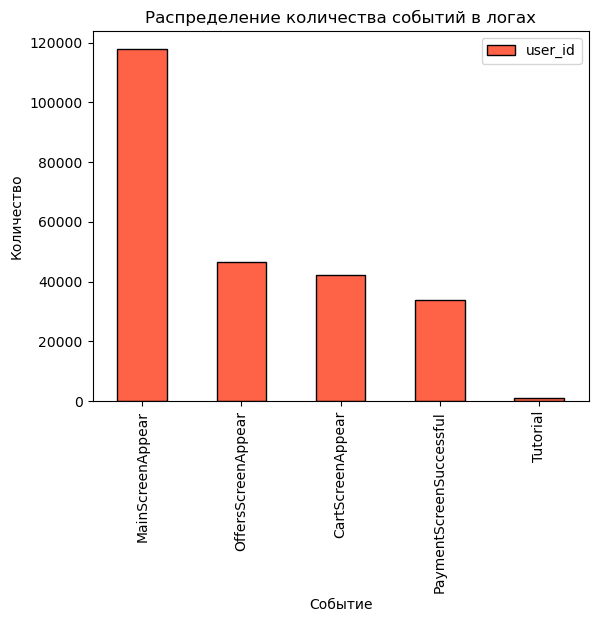

In [21]:
events_count.sort_values(by='user_id',ascending = False).plot(kind='bar',title='Распределение количества событий в логах', color = "tomato",edgecolor = 'black') 
plt.xlabel("Событие")
plt.ylabel("Количество")
plt.show()

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. 

In [22]:
users_count = new_logs.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)
users_count = users_count.reset_index()
users_count

,event_name,user_id
0,MainScreenAppear,7423
1,OffersScreenAppear,4597
2,CartScreenAppear,3736
3,PaymentScreenSuccessful,3540
4,Tutorial,843


Главную страницу посмотрели 7423 пользователей;

Перешли на страницу предложений 4597 пользователей;

Перешли на страницу "корзина" 3736 пользователей;

Перешли на страницу "оплата" 3540 пользователей;

Перешли на страницу "руководство" 843 пользователя.

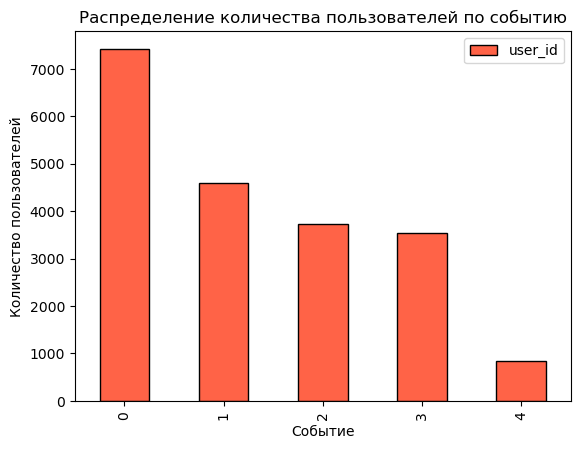

In [23]:
users_count.sort_values(by = 'user_id', ascending = False).plot(kind='bar',title='Распределение количества пользователей по событию', color = "tomato",edgecolor = 'black') 
plt.xlabel("Событие")
plt.ylabel("Количество пользователей")
plt.show()

Построим воронку с количеством уникальных пользователей на каждом из шагов:

In [24]:
fig = go.Figure(go.Funnel(
    y = users_count['event_name'],
    x = users_count['user_id'],
    textinfo = "value+percent initial"))

fig.show()

Посчитаем долю пользователей, которые хоть раз совершали событие:

In [25]:
users_count_1 = new_logs['user_id'].nunique()
users_count_1

7538

In [26]:
users_count_1 = new_logs['user_id'].nunique()
users = users_count['event_name'].reset_index()
users['percent'] = round((users_count['user_id']/users_count_1) * 100,2)
display(users[['event_name','percent']])

,event_name,percent
0,MainScreenAppear,98.47
1,OffersScreenAppear,60.98
2,CartScreenAppear,49.56
3,PaymentScreenSuccessful,46.96
4,Tutorial,11.18


Можно предположить, что события происходят в таком порядке:
1. MainScreenAppear (посмотреть главную страницу)
2. OffersScreenAppear (перейти на страницу предложений)
3. CartScreenAppear (перейти на страницу "корзина")
4. PaymentScreenSuccessful (перейти на страницу "оплата")
5. Tutorial (перейти на страницу "руководство") - не будем учитывать данное событие, так как оно редко используется пользователями.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [27]:
users_count = users_count [:-1]
users_count ['percent'] = round(users_count['user_id']/users_count['user_id'].shift()*100, 2)
users_count [1:]

,event_name,user_id,percent
1,OffersScreenAppear,4597,61.93
2,CartScreenAppear,3736,81.27
3,PaymentScreenSuccessful,3540,94.75


Доля пользователей, перешедших с главной страницы на страницу предложения: 61.93 % Доля пользователей, перешедших со страницы предложения на страницу "корзина": 81.27 % Доля пользователей, перешедших со страницы "корзина" на страницу "оплата": 94.75 %

Определим, на каком шаге мы теряем больше всего пользователей:

In [28]:
users_count = new_logs.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)
users_count = users_count [:-1]
users_count ['lost'] = round(users_count['user_id']-users_count['user_id'].shift())
users_count [1:]

,user_id,lost
event_name,,
OffersScreenAppear,4597,-2826.0
CartScreenAppear,3736,-861.0
PaymentScreenSuccessful,3540,-196.0


После перехода на страницу предложения потеряно 2826 пользователей;

После перехода в корзину потеряно 861 пользователь;

После перехода на оплату потеряно 196 пользователей.

Оказывается, больше всего пользователей теряется после перехода на страницу предложений, то есть многие пользователи просматривают только главную страницу.

Определим, какая доля пользователей доходит от первого события до оплаты:

In [29]:
percent_4 = users_count['user_id'].iloc[3]/users_count['user_id'].iloc[0]*100

print('Доля пользователей, которая дошла от первого события до оплаты:', round(percent_4,2),'%')

Доля пользователей, которая дошла от первого события до оплаты: 47.69 %


На этапе изучения воронки событий, мы определили, как часто встречается каждое событие и сколько пользователей совершало каждое из этих событий; так же определили долю пользователей, которые хоть раз совершали каждое из событий.
Предположили, что события происходят в таком порядке:
1. MainScreenAppear (посмотреть главную страницу)
2. OffersScreenAppear (перейти на страницу предложений)
3. CartScreenAppear (перейти на страницу "корзина")
4. PaymentScreenSuccessful (перейти на страницу "оплата")
5. Tutorial (перейти на страницу "руководство") 

Далее, мы по воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки; определили, на каком шаге мы теряем больше всего пользователей (после перехода на страницу предложений). Так же оказалось, что доля пользователей, которая дошла от первого события до оплаты составляет 47.69 %.

### Изучение результатов эксперимента

Определим, cколько пользователей в каждой экспериментальной группе:

In [30]:
new_logs.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
246,2484
247,2517
248,2537


По всем событиям посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. 

Сформулируем гипотезы: Нулевая гипотеза:  Доли уникальных пользователей, побывавших на этапе воронки, одинаковы. Альтернативная гипотеза: Между долями уникальных пользователей, побывавших на этапе воронки, есть значимая разница.

In [31]:
alpha = .05 # критический уровень статистической значимости

def test (successes, trials): # функция проверки z-критерия на равенство долей 
    # пропорция успехов в первой группе
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе
    p2 = successes[1]/trials[1]
    # пропорция успехов в комбинированном датасете
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = (difference / mth.sqrt(p_combined*(1 - p_combined) * (1/trials[0] + 1/trials[1])))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('р-значение:', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")

In [32]:
def event(event_name):
    print(event_name,':')
    event_groups = new_logs.loc[(new_logs['event_name'] == event_name)].groupby('group').agg({'user_id':'nunique'})
    event_groups.columns = ['users_count']
    event_groups['users_total'] = new_logs.groupby('group').agg({'user_id':'nunique'})
    event_groups['percent'] = round(event_groups['users_count']/ event_groups['users_total'] * 100, 2) 
    event_groups.loc['246+247']=event_groups.loc[246]+event_groups.loc[247]
    display(event_groups)

event('MainScreenAppear')
event('OffersScreenAppear')
event('CartScreenAppear')
event('PaymentScreenSuccessful')    

MainScreenAppear :


,users_count,users_total,percent
group,,,
246,2450.0,2484.0,98.63
247,2479.0,2517.0,98.49
248,2494.0,2537.0,98.31
246+247,4929.0,5001.0,197.12


OffersScreenAppear :


,users_count,users_total,percent
group,,,
246,1542.0,2484.0,62.08
247,1524.0,2517.0,60.55
248,1531.0,2537.0,60.35
246+247,3066.0,5001.0,122.63


CartScreenAppear :


,users_count,users_total,percent
group,,,
246,1266.0,2484.0,50.97
247,1239.0,2517.0,49.23
248,1231.0,2537.0,48.52
246+247,2505.0,5001.0,100.20


PaymentScreenSuccessful :


,users_count,users_total,percent
group,,,
246,1200.0,2484.0,48.31
247,1158.0,2517.0,46.01
248,1182.0,2537.0,46.59
246+247,2358.0,5001.0,94.32


In [33]:
def events(event_name, group_1, group_2): 
    print(event_name,':')
    event_groups = new_logs.loc[(new_logs['event_name'] == event_name) & (new_logs['group'].isin([group_1, group_2]))].groupby('group').agg({'user_id':'nunique'})
    event_groups.columns = ['users_count']
    event_groups['users_total'] = new_logs.groupby('group').agg({'user_id':'nunique'})
    event_groups['percent'] = round(event_groups['users_count']/ event_groups['users_total'] * 100, 2) 
    test(np.array(event_groups['users_count']), np.array(event_groups['users_total']))

print('Группы 246 и 247: ')
events('MainScreenAppear',246,247)
events('OffersScreenAppear',246,247)
events('CartScreenAppear',246,247)
events('PaymentScreenSuccessful',246,247)

Группы 246 и 247: 
MainScreenAppear :
р-значение: 0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
OffersScreenAppear :
р-значение: 0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
CartScreenAppear :
р-значение: 0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
PaymentScreenSuccessful :
р-значение: 0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


По полученным результатам, можно сделать вывод, что по всем событиям нет оснований считать, что между группами есть статистически значимое различие. 

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. 

In [34]:
print('Группы 246 и 248: ')
events('MainScreenAppear',246,248)
events('OffersScreenAppear',246,248)
events('CartScreenAppear',246,248)
events('PaymentScreenSuccessful',246,248)

Группы 246 и 248: 
MainScreenAppear :
р-значение: 0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
OffersScreenAppear :
р-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
CartScreenAppear :
р-значение: 0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
PaymentScreenSuccessful :
р-значение: 0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


По полученным результатам, можно сделать вывод, что по всем событиям нет оснований считать, что между контрольной группой 246 и экспериментальной группой 248 есть статистически значимое различие. 

In [35]:
print('Группы 247 и 248: ')
events('MainScreenAppear',247,248)
events('OffersScreenAppear',247,248)
events('CartScreenAppear',247,248)
events('PaymentScreenSuccessful',247,248)

Группы 247 и 248: 
MainScreenAppear :
р-значение: 0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
OffersScreenAppear :
р-значение: 0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
CartScreenAppear :
р-значение: 0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
PaymentScreenSuccessful :
р-значение: 0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


По полученным результатам, можно сделать вывод, что по всем событиям нет оснований считать, что между контрольной группой 247 и экспериментальной группой 248 есть статистически значимое различие. 

Сравним результаты с объединённой контрольной группой.

In [36]:
def events_1(event_name):
    event_groups = new_logs.loc[(new_logs['event_name'] == event_name) & (new_logs['group'].isin([246, 247, 248]))].groupby('group').agg({'user_id':'nunique'})
    event_groups.columns = ['users_count']
    event_groups['users_total'] = new_logs.groupby('group').agg({'user_id':'nunique'})
    event_groups['percent'] = round(event_groups['users_count']/ event_groups['users_total'] * 100, 2) 
    event_groups.loc['246+247']=event_groups.loc[246]+event_groups.loc[247]
    event_groups = event_groups.drop (index=[246, 247])
    test(np.array(event_groups['users_count']), np.array(event_groups['users_total']))

print('Группы 246+247 и 248: ')
events_1('MainScreenAppear')
events_1('OffersScreenAppear')
events_1('CartScreenAppear')
events_1('PaymentScreenSuccessful')

Группы 246+247 и 248: 
р-значение: 0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
р-значение: 0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
р-значение: 0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
р-значение: 0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


По полученным результатам, так же можно сделать вывод, что по всем событиям нет оснований считать, что между объединенной контрольной группой  и экспериментальной группой есть статистически значимое различие. 

Попробуем проделать те же самые действия, при уровне значимости, равным 0.1:

In [37]:
alpha = .1 # критический уровень статистической значимости

print('Группы 246 и 247: ')
events('MainScreenAppear',246,247)
events('OffersScreenAppear',246,247)
events('CartScreenAppear',246,247)
events('PaymentScreenSuccessful',246,247)

Группы 246 и 247: 
MainScreenAppear :
р-значение: 0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
OffersScreenAppear :
р-значение: 0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
CartScreenAppear :
р-значение: 0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
PaymentScreenSuccessful :
р-значение: 0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


In [38]:
print('Группы 246 и 248: ')
events('MainScreenAppear',246,248)
events('OffersScreenAppear',246,248)
events('CartScreenAppear',246,248)
events('PaymentScreenSuccessful',246,248)

Группы 246 и 248: 
MainScreenAppear :
р-значение: 0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
OffersScreenAppear :
р-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
CartScreenAppear :
р-значение: 0.08328412977507749
Отвергаем нулевую гипотезу: между группами есть значимая разница
PaymentScreenSuccessful :
р-значение: 0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


In [39]:
print('Группы 247 и 248: ')
events('MainScreenAppear',247,248)
events('OffersScreenAppear',247,248)
events('CartScreenAppear',247,248)
events('PaymentScreenSuccessful',247,248)

Группы 247 и 248: 
MainScreenAppear :
р-значение: 0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
OffersScreenAppear :
р-значение: 0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
CartScreenAppear :
р-значение: 0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
PaymentScreenSuccessful :
р-значение: 0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


In [40]:
print('Группы 246+247 и 248: ')
events_1('MainScreenAppear')
events_1('OffersScreenAppear')
events_1('CartScreenAppear')
events_1('PaymentScreenSuccessful')

Группы 246+247 и 248: 
р-значение: 0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
р-значение: 0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
р-значение: 0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
р-значение: 0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


По событию CartScreenAppear между группами 246 и 248 есть статистически значимое различие, в остальных случаях нет оснований считать группы разными.

При выборе порогового значения необходимо обращать внимание на объем выборки; при малом объеме выборки более вероятно получить случайный результат, например, различия в двух однородных выборках. А при большом объеме выборки, случайные отклонения компенсируют друг друга и получить значимое различие в однородных выборках менее вероятно, поэтому надо брать меньший уровень значимости. Так как выборка у нас небольшая, то уровень значимости равный 0.05 будет оптимальным, при 0.1 уже появляется ошибка первого рода. Выбирая уровень значимости, равный 0.05, то допускаем, что с вероятностью 5/100 результат можент оказаться ложноположительным. Так как у нас идет множественная проверка гипотез, увеличивается риск ложноположительного результата, и можно найти различия там, где их на самом деле нет.

# Вывод

В данном исследовании мы использовали данные за период с 2019-07-31 21:00:57 по 2019-08-07 21:15:17.

При изучении воронки продаж, мы выяснили, что пользователи доходят до покупки в таком порядке:
1. MainScreenAppear (посмотреть главную страницу)
2. OffersScreenAppear (перейти на страницу предложений)
3. CartScreenAppear (перейти на страницу "корзина")
4. PaymentScreenSuccessful (перейти на страницу "оплата")
5. Tutorial (перейти на страницу "руководство") 

Определили, что после перехода на страницу предложений теряется 3220 пользователей, после перехода в корзину теряется 2422 пользователей,а после перехода на оплату теряется 1323 пользователей.
Доля пользователей, которая дошла от первого события до оплаты составляет 6.17 %.

Далее, мы исследовали результаты A/A/B-эксперимента. Между двумя контрольными группами не оказалось статистически значимой разницы, следовательно тестирование было проведено верно.
 
Судя по полученным результатам, на поведение пользователей изменение шрифта сильно не повлияло (непривычно им не стало). 
Следовательно, дизайнеры могут поменять шрифт во всем приложении, и это не отпугнет пользователей.